In [ ]:

import pandas as pd
import numpy as np
import torch
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import random
import shutil
from google.colab import drive, files


In [ ]:
# Mount Google Drive to access datasets
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except:
    print("Running in a local environment without Google Drive access.")

# Define paths for datasets
datasets = {
    "Barishal": "/content/drive/MyDrive/Dataset/Barishal/Barishal Text Translation.csv",
    "Chittagong": "/content/drive/MyDrive/Dataset/Chittagong/Chittagong Text Translation.csv",
    "Noakhali": "/content/drive/MyDrive/Dataset/Noakhali/Noakhali Text Translation.csv",
    "Sylhet": "/content/drive/MyDrive/Dataset/Sylhet/Sylhet Text Translation.csv",
    "Mymensingh": "/content/drive/MyDrive/Dataset/Mymensingh/Mymensingh Text Translation.csv"
}

Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

In [ ]:
# Read all datasets into a dictionary of DataFrames
dataframes = {region: pd.read_csv(path, encoding="utf-8") for region, path in datasets.items()}


In [ ]:
# Define the columns that represent the dialects
region_columns = [
    "Barishal_Language", "Chittagong_Language", "Noakhali_Language",
    "Sylhet_Language", "Mymensingh_Language"
]

In [ ]:
# Data Augmentation for minority classes
def augment_text(text):
    """Simple augmentation by character substitution for similar sounding characters"""
    substitutions = {
        'া': 'া', 'ি': 'ী', 'ু': 'ূ', 'ে': 'ৈ',
        'ো': 'ৌ', 'ক': 'খ', 'গ': 'ঘ', 'চ': 'ছ',
        'জ': 'য', 'ট': 'ঠ', 'ড': 'ঢ', 'ত': 'থ',
        'দ': 'ধ', 'প': 'ফ', 'ব': 'ভ', 'স': 'শ'
    }

    augmented = list(text)
    # Apply random substitutions with 15% probability per character
    for idx, char in enumerate(augmented):
        if char in substitutions and random.random() < 0.15:
            augmented[idx] = substitutions[char]

    return ''.join(augmented)

In [ ]:
# Dialect-specific marker detection
def add_dialect_marker_counts(df_long):
    """Add dialect marker counts as features"""
    # Define dialect markers (these are examples - you should expand with real markers)
    markers = {
        'Sylhet': ['আইজ', 'আফনে', 'খাইছিন', 'খাইতাম', 'আইসলাম', 'কিতা'],
        'Chittagong': ['আন্নে', 'নাকি', 'কুন', 'কেনে', 'আইচ্ছে', 'কইবা'],
        'Barishal': ['আইতাছে', 'কইরা', 'হালা', 'কইন', 'কইরলাম', 'কইস'],
        'Noakhali': ['আইয়া', 'গেলাম', 'কথা', 'কইতাম', 'খাইমু', 'ফোইলা'],
        'Mymensingh': ['কইতাছে', 'আমরা', 'কইরেন', 'বাড়ি', 'খাইমু', 'কইলাম']
    }

    def count_dialect_markers(text, region):
        """Count how many dialect-specific markers are in the text"""
        if region not in markers:
            return 0

        count = 0
        for marker in markers[region]:
            if marker in text:
                count += 1
        return count

    # Add marker count feature
    df_long['dialect_marker_count'] = df_long.apply(
        lambda row: count_dialect_markers(row['Dialect_Text'], row['Region']),
        axis=1
    )

    # Add text length feature
    df_long['text_length'] = df_long['Dialect_Text'].apply(len)

    return df_long


In [ ]:
# Create a list to store transformed data
data_list = []
# Iterate over each region and create separate DataFrames
for region_col in region_columns:
    region_name = region_col.replace("_Language", "")
    print(f"Processing region: {region_name}")

    matching_df = next((
        df for df_region, df in dataframes.items()
        if region_name.lower() in df_region.lower()
        and region_col in df.columns
        and "Standard_Bangla_Language" in df.columns
    ), None)

    if matching_df is not None:
        print(f"Found matching dataframe for {region_name}")

        temp_df = matching_df[["Standard_Bangla_Language", region_col]].copy()
        temp_df.columns = ["Standard_Bangla", "Dialect_Text"]
        temp_df["Region"] = region_name
        temp_df.dropna(inplace=True)

        print(f"Original rows for {region_name}: {len(temp_df)}")

        if region_name in ["Barishal", "Mymensingh"]:
            augmented_df = pd.DataFrame([
                {
                    "Standard_Bangla": row["Standard_Bangla"],
                    "Dialect_Text": augment_text(row["Dialect_Text"]),
                    "Region": region_name
                }
                for _, row in temp_df.iterrows()
            ])
            temp_df = pd.concat([temp_df, augmented_df], ignore_index=True)
            print(f"Added {len(augmented_df)} augmented samples for {region_name}")

        print(f"Final rows for {region_name} after augmentation: {len(temp_df)}")
        data_list.append(temp_df)
    else:
        print(f"Warning: No matching dataframe found for region {region_name}")

# Combine all DataFrames if available
if data_list:
    df_long = pd.concat(data_list, ignore_index=True)
    df_long = add_dialect_marker_counts(df_long)
    print("Dataframes concatenated successfully.")
else:
    print("Error: data_list is empty. Cannot concatenate.")


Processing region: Barishal
Found matching dataframe for Barishal
Original rows for Barishal: 4082
Added 4082 augmented samples for Barishal
Final rows for Barishal after augmentation: 8164
Processing region: Chittagong
Found matching dataframe for Chittagong
Original rows for Chittagong: 12212
Final rows for Chittagong after augmentation: 12212
Processing region: Noakhali
Found matching dataframe for Noakhali
Original rows for Noakhali: 5488
Final rows for Noakhali after augmentation: 5488
Processing region: Sylhet
Found matching dataframe for Sylhet
Original rows for Sylhet: 6204
Final rows for Sylhet after augmentation: 6204
Processing region: Mymensingh
Found matching dataframe for Mymensingh
Original rows for Mymensingh: 2500
Added 2500 augmented samples for Mymensingh
Final rows for Mymensingh after augmentation: 5000
Dataframes concatenated successfully.


In [ ]:
# Encode region labels
region_labels = {region: idx for idx, region in enumerate(df_long["Region"].unique())}
df_long["Region_Label"] = df_long["Region"].map(region_labels)

print("Dataset distribution:")
print(df_long["Region"].value_counts())

print("Encoded Region Labels:")
print(region_labels)

Dataset distribution:
Region
Chittagong    12212
Barishal       8164
Sylhet         6204
Noakhali       5488
Mymensingh     5000
Name: count, dtype: int64
Encoded Region Labels:
{'Barishal': 0, 'Chittagong': 1, 'Noakhali': 2, 'Sylhet': 3, 'Mymensingh': 4}


In [ ]:
 #Calculate class weights inversely proportional to class frequencies for handling imbalance
class_counts = df_long["Region_Label"].value_counts()
total_samples = len(df_long)
class_weights = {label: total_samples / count for label, count in class_counts.items()}
print("\nClass weights:")
print(class_weights)


Class weights:
{1: 3.035375040943334, 0: 4.540421362077413, 3: 5.974854932301741, 2: 6.754373177842566, 4: 7.4136}


In [ ]:
#Implement K-fold cross validation
# Number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [ ]:
# Load a pre-trained Bangla BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [ ]:
# Improved tokenization with longer sequence length
def tokenize_data(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

In [ ]:
# Create Dataset class
class DialectDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
# Define compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
# Custom trainer with class weights
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")

        # Apply weighted loss if class weights are provided
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.args.device))
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss = outputs.get("loss")

        return (loss, outputs) if return_outputs else loss

In [ ]:
def predict_region(text, model, tokenizer, region_labels):

    idx_to_region = {v: k for k, v in region_labels.items()}

    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    top_class = torch.argmax(outputs.logits, dim=-1).item()

    return idx_to_region[top_class]


In [ ]:
# IMPROVEMENT 7: Store results from each fold for ensemble prediction
fold_results = []
fold_models = []

# Convert the class_weights dictionary to a PyTorch tensor
class_weights_tensor = torch.tensor([class_weights[label] for label in sorted(class_weights.keys())], dtype=torch.float32)


In [ ]:
# Implement K-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kf.split(df_long)):
    print(f"\n{'='*40}\nFold {fold+1}/{k_folds}\n{'='*40}")

    # Split data for this fold
    train_df = df_long.iloc[train_idx]
    val_df = df_long.iloc[val_idx]

    # Extract texts and labels
    train_texts = train_df["Dialect_Text"].reset_index(drop=True)
    train_labels = train_df["Region_Label"].reset_index(drop=True)
    val_texts = val_df["Dialect_Text"].reset_index(drop=True)
    val_labels = val_df["Region_Label"].reset_index(drop=True)

    # Tokenize datasets
    train_encodings = tokenize_data(train_texts)
    val_encodings = tokenize_data(val_texts)

    # Create dataset objects
    train_dataset = DialectDataset(train_encodings, train_labels)
    val_dataset = DialectDataset(val_encodings, val_labels)

    # Load a pre-trained BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained(
        'sagorsarker/bangla-bert-base', num_labels=len(region_labels)
    )

    # IMPROVEMENT 8: Optimized training arguments
    training_args = TrainingArguments(
        output_dir=f'./improved_results/fold_{fold+1}',
        num_train_epochs=5,  # Increased from 3 to allow better learning
        per_device_train_batch_size=8,  # Reduced batch size to allow more gradient updates
        per_device_eval_batch_size=16,
        warmup_ratio=0.1,  # Use ratio instead of steps for better scaling
        weight_decay=0.01,
        logging_dir=f'./logs/fold_{fold+1}',
        logging_steps=100,
        save_strategy="epoch",  # Save model after each epoch
        eval_strategy="epoch",
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="f1",  # Use F1 score to determine the best model
        greater_is_better=True,  # Higher F1 score is better
        learning_rate=2e-5,  # Slightly lower learning rate
        lr_scheduler_type="linear",  # Linear learning rate scheduler
        report_to="none"  # Disable wandb/tensorboard reporting
    )

    # IMPROVEMENT 9: Early stopping
    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

    # Initialize the custom trainer with class weights
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        class_weights=class_weights_tensor,  # Use the class weights tensor
        callbacks=[early_stopping_callback]
    )

    # Train the model
    print(f"Training fold {fold+1}...")
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Fold {fold+1} evaluation results: {eval_results}")

    # Save results and model
    fold_results.append(eval_results)
    fold_models.append(model)

    # Generate confusion matrix for this fold
    test_outputs = trainer.predict(val_dataset)
    preds = np.argmax(test_outputs.predictions, axis=-1)

    # Create confusion matrix
    cm = confusion_matrix(val_labels, preds)

    # Convert indices to region names for better visualization
    idx_to_region = {v: k for k, v in region_labels.items()}
    region_names = [idx_to_region[i] for i in range(len(region_labels))]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=region_names, yticklabels=region_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_fold_{fold+1}.png')
    plt.close()


Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 1...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.392600,0.406814,0.871729,0.871525,0.874949,0.871729
2,0.258400,0.384007,0.900189,0.900864,0.902264,0.900189
3,0.214400,0.418815,0.909765,0.909853,0.910587,0.909765
4,0.192100,0.434476,0.919477,0.919218,0.919059,0.919477
5,0.072600,0.484586,0.922714,0.922477,0.922454,0.922714


Fold 1 evaluation results: {'eval_loss': 0.48458632826805115, 'eval_accuracy': 0.9227137847315889, 'eval_f1': 0.9224770622992251, 'eval_precision': 0.9224540065345842, 'eval_recall': 0.9227137847315889, 'eval_runtime': 22.9519, 'eval_samples_per_second': 323.023, 'eval_steps_per_second': 20.216, 'epoch': 5.0}

Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 2...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.499700,0.399321,0.869436,0.868433,0.872571,0.869436
2,0.368100,0.378181,0.906663,0.906613,0.907089,0.906663
3,0.309800,0.406130,0.920016,0.920155,0.920679,0.920016
4,0.141200,0.427696,0.924332,0.924506,0.925126,0.924332
5,0.072700,0.447102,0.927974,0.928027,0.928298,0.927974


Fold 2 evaluation results: {'eval_loss': 0.4471023678779602, 'eval_accuracy': 0.927974103048287, 'eval_f1': 0.9280272992148458, 'eval_precision': 0.9282980634187402, 'eval_recall': 0.927974103048287, 'eval_runtime': 23.0075, 'eval_samples_per_second': 322.243, 'eval_steps_per_second': 20.167, 'epoch': 5.0}

Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 3...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.426000,0.394415,0.871459,0.872214,0.874538,0.871459
2,0.358100,0.383162,0.902617,0.902645,0.902998,0.902617
3,0.191400,0.434418,0.913947,0.913960,0.914034,0.913947
4,0.139400,0.452828,0.915835,0.915198,0.916097,0.915835
5,0.070000,0.481219,0.920825,0.920565,0.920502,0.920825


Fold 3 evaluation results: {'eval_loss': 0.4812188148498535, 'eval_accuracy': 0.9208254653358511, 'eval_f1': 0.9205654085456099, 'eval_precision': 0.9205021352338004, 'eval_recall': 0.9208254653358511, 'eval_runtime': 22.9718, 'eval_samples_per_second': 322.744, 'eval_steps_per_second': 20.199, 'epoch': 5.0}

Fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 4...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.442800,0.485521,0.859976,0.857322,0.861330,0.859976
2,0.331000,0.405513,0.899096,0.899344,0.902273,0.899096
3,0.237100,0.409692,0.913935,0.914141,0.914842,0.913935
4,0.193400,0.444979,0.915958,0.916065,0.916300,0.915958
5,0.086600,0.488028,0.919601,0.919419,0.919633,0.919601


Fold 4 evaluation results: {'eval_loss': 0.48802846670150757, 'eval_accuracy': 0.9196007014703899, 'eval_f1': 0.9194194053064693, 'eval_precision': 0.9196326194398212, 'eval_recall': 0.9196007014703899, 'eval_runtime': 23.0389, 'eval_samples_per_second': 321.759, 'eval_steps_per_second': 20.14, 'epoch': 5.0}

Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 5...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.493500,0.384785,0.869823,0.869936,0.874726,0.869823
2,0.357100,0.397654,0.896938,0.897380,0.901902,0.896938
3,0.180900,0.429646,0.912181,0.911796,0.911865,0.912181
4,0.204200,0.437094,0.921085,0.921099,0.921280,0.921085
5,0.047200,0.467491,0.924862,0.924891,0.925100,0.924862


Fold 5 evaluation results: {'eval_loss': 0.4674912393093109, 'eval_accuracy': 0.9248617293943073, 'eval_f1': 0.924890761254335, 'eval_precision': 0.9250995064954276, 'eval_recall': 0.9248617293943073, 'eval_runtime': 22.9194, 'eval_samples_per_second': 323.438, 'eval_steps_per_second': 20.245, 'epoch': 5.0}


In [ ]:

# Find the best fold based on F1 score
best_fold_idx = max(range(len(fold_results)), key=lambda i: fold_results[i].get('eval_f1', 0))
best_model = fold_models[best_fold_idx]
best_eval_results = fold_results[best_fold_idx]

print(f"\nBest model is from fold {best_fold_idx+1} with F1 score: {best_eval_results.get('eval_f1', 0):.4f}")



Best model is from fold 2 with F1 score: 0.9280


In [ ]:
# Calculate average metrics across all folds
avg_metrics = {
    'accuracy': sum(result.get('eval_accuracy', 0) for result in fold_results) / len(fold_results),
    'f1': sum(result.get('eval_f1', 0) for result in fold_results) / len(fold_results),
    'precision': sum(result.get('eval_precision', 0) for result in fold_results) / len(fold_results),
    'recall': sum(result.get('eval_recall', 0) for result in fold_results) / len(fold_results)
}

print("\nAverage metrics across all folds:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")



Average metrics across all folds:
accuracy: 0.9232
f1: 0.9231
precision: 0.9232
recall: 0.9232


In [ ]:
# Save the best model
best_model_dir = './improved_dialect_model'
os.makedirs(best_model_dir, exist_ok=True)
best_model.save_pretrained(best_model_dir)
tokenizer.save_pretrained(best_model_dir)

# Save region labels mapping
with open(os.path.join(best_model_dir, "region_labels.json"), "w", encoding="utf-8") as f:
    json.dump(region_labels, f, ensure_ascii=False, indent=4)

print(f"Best model saved to {best_model_dir}")

Saving vocabulary to ./improved_dialect_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./improved_dialect_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./improved_dialect_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./improved_dialect_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./improved_dialect_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./improved_dialect_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./improved_dialect_model/vocab.txt: vocabulary indices are not consecutive. Please check th

Best model saved to ./improved_dialect_model


In [ ]:
import os, json

save_dir = "/content/improved_bangla_bert_base_model"
os.makedirs(save_dir, exist_ok=True)

# Save model
best_model.save_pretrained(save_dir)

# Save tokenizer
tokenizer.save_pretrained(save_dir)

# Save region label mapping
with open(os.path.join(save_dir, "region_labels.json"), "w", encoding="utf-8") as f:
    json.dump(region_labels, f, ensure_ascii=False, indent=4)

print("Model, tokenizer, and region labels saved.")


Saving vocabulary to /content/improved_bangla_bert_base_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/improved_bangla_bert_base_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/improved_bangla_bert_base_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/improved_bangla_bert_base_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/improved_bangla_bert_base_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/improved_bangla_bert_base_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabular

✅ Model, tokenizer, and region labels saved.


In [ ]:
import shutil

zip_path = shutil.make_archive(save_dir, 'zip', save_dir)
print(f"Folder zipped at: {zip_path}")
from google.colab import files

files.download(zip_path)
print("Zip file download started.")

Folder zipped at: /content/improved_bangla_bert_base_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zip file download started.


In [ ]:
# Define a function to predict the region
def predict_region_example(text, model, tokenizer, region_labels):

    prediction_result = predict_region(text, model, tokenizer, region_labels)
    return prediction_result['region']

# Example usage
input_text = "ফুয়াাটায় তার গাউর ছুটো এখটা ইস্কুল থাকি পড়িয়া এসএসসি পাশ খরছে"
predicted_region = predict_region(input_text, best_model, tokenizer, region_labels)
print(f"Predicted Region: {predicted_region}")


Predicted Region: Sylhet


In [ ]:
# Define a function to predict the region
def predict_region_example(text, model, tokenizer, region_labels):

    prediction_result = predict_region(text, model, tokenizer, region_labels)
    return prediction_result['region']

# Example usage
input_text = "বউদ্দিন ফর এক্কান বালা চবি দেইলাম"
predicted_region = predict_region(input_text, best_model, tokenizer, region_labels) # Use the best_model obtained from cross-validation
print(f"Predicted Region: {predicted_region}")


Predicted Region: Chittagong


In [ ]:
# Test the model with some examples
test_examples = [
    "বেশি গম লিকখো",
    "আঁই যানি এডে বউত মাইফোয়া কমেন্ট ফরিবার লাই আইবো",
    "আন্নেগর কি শুক্কুরবার সকালে সময় অইব"
]

for text in test_examples:
    region = predict_region(text, best_model, tokenizer, region_labels)
    print(f"\nText: {text}")
    print(f"Predicted Region: {region}")



Text: বেশি গম লিকখো
Predicted Region: Chittagong

Text: আঁই যানি এডে বউত মাইফোয়া কমেন্ট ফরিবার লাই আইবো
Predicted Region: Chittagong

Text: আন্নেগর কি শুক্কুরবার সকালে সময় অইব
Predicted Region: Noakhali


In [ ]:
# Helper function to load the saved model for future use
def load_model(model_path=best_model_dir):
    """Load the improved dialect detection model from saved path"""
    model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)

    # Load region labels
    with open(os.path.join(model_path, "region_labels.json"), "r", encoding="utf-8") as f:
        region_labels = json.load(f)

    return model, tokenizer, region_labels

In [ ]:
# prompt: give me final error metric

print("\nFinal Average Evaluation Metrics Across All Folds:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Average Evaluation Metrics Across All Folds:
accuracy: 0.9232
f1: 0.9231
precision: 0.9232
recall: 0.9232


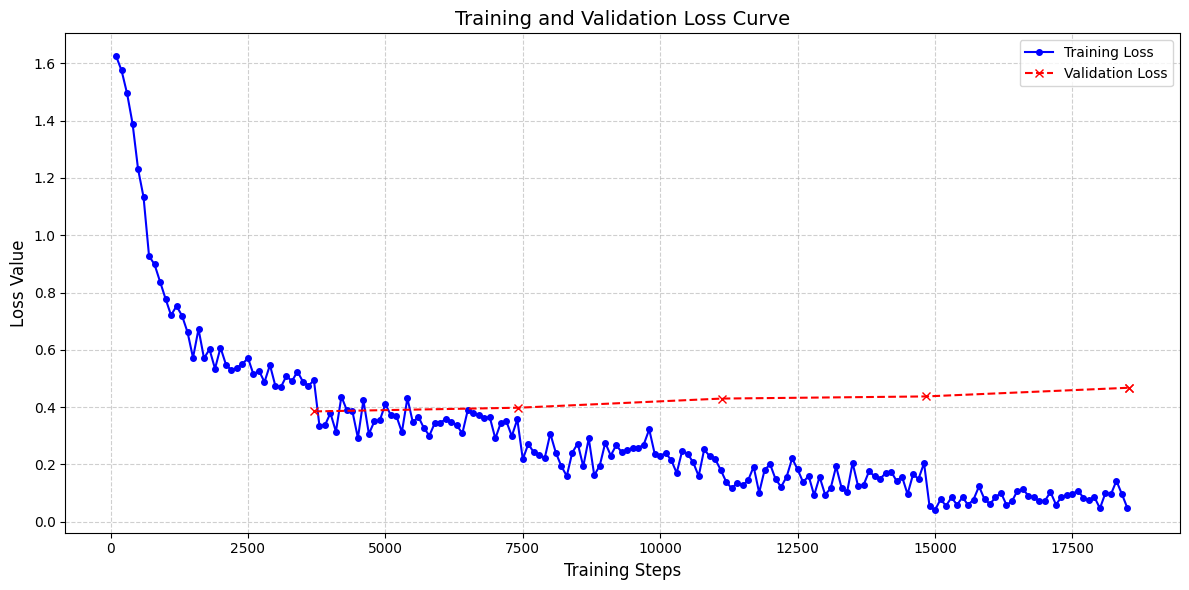


Note: The x-axis represents training steps. Validation loss is plotted at the steps where evaluation occurred.


In [ ]:
# prompt: give me graph for traning loss and validation loss
# grpah is not good
# so give and I will be added in the research paper

import matplotlib.pyplot as plt
# Access the trainer's state to get logs
# Assuming the trainer variable is available from the preceding code
# If not, you would need to re-instantiate or find a way to access the training logs.
# In this specific case, the logs are stored in trainer.state.log_history

logs = trainer.state.log_history

# Extract training and evaluation loss from logs
train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
eval_steps = [entry['step'] for entry in logs if 'eval_loss' in entry]

# Calculate the number of training steps per epoch for plotting
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
train_steps = [(i + 1) * training_args.logging_steps for i in range(len(train_loss))]

plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.plot(train_steps, train_loss, label='Training Loss', color='blue', marker='o', linestyle='-', markersize=4)

# Plot Validation Loss (aligned with evaluation steps)
# We need to make sure the eval_loss points correspond to the correct steps
# The log_history records eval_loss at specific steps, so we use those steps.
plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red', marker='x', linestyle='--', markersize=6)


plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Training and Validation Loss Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

print("\nNote: The x-axis represents training steps. Validation loss is plotted at the steps where evaluation occurred.")


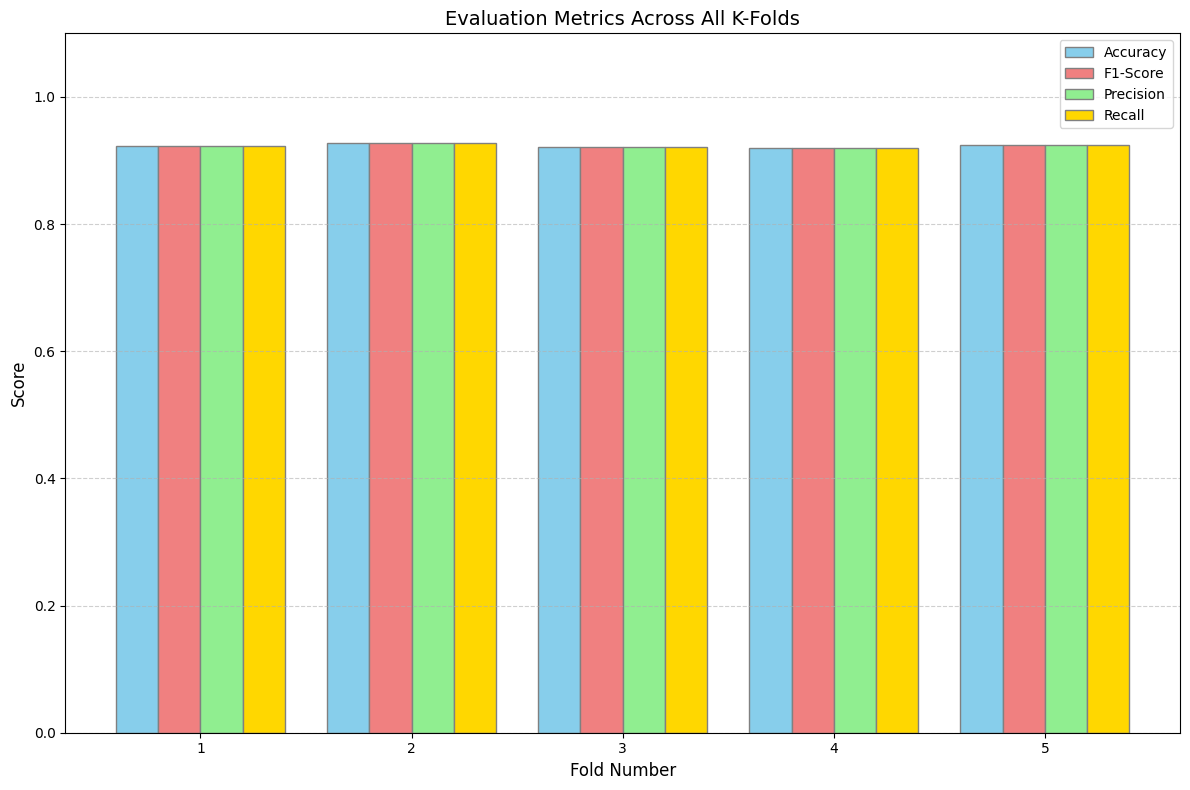


This graph shows the performance metrics (Accuracy, F1-Score, Precision, Recall) for each of the 5 cross-validation folds.


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Extract metrics for plotting from fold_results
folds = range(1, k_folds + 1)
eval_accuracy = [result.get('eval_accuracy', 0) for result in fold_results]
eval_f1 = [result.get('eval_f1', 0) for result in fold_results]
eval_precision = [result.get('eval_precision', 0) for result in fold_results]
eval_recall = [result.get('eval_recall', 0) for result in fold_results]

# Plotting
plt.figure(figsize=(12, 8))

bar_width = 0.2

r1 = np.arange(len(folds))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.bar(r1, eval_accuracy, color='skyblue', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, eval_f1, color='lightcoral', width=bar_width, edgecolor='grey', label='F1-Score')
plt.bar(r3, eval_precision, color='lightgreen', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r4, eval_recall, color='gold', width=bar_width, edgecolor='grey', label='Recall')

plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Evaluation Metrics Across All K-Folds', fontsize=14)
plt.xticks([r + bar_width*1.5 for r in range(len(folds))], folds) # Adjust x-ticks positions
plt.ylim(0, 1.1) # Set y-axis limit from 0 to 1.1 to better visualize scores
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nThis graph shows the performance metrics (Accuracy, F1-Score, Precision, Recall) for each of the 5 cross-validation folds.")
